In [1]:
import pandas as pd

# Load sentiment data and ensure correct datetime
sentiment = pd.read_csv("fear_greed_index.csv", parse_dates=["timestamp"])
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date  # already present

# Load trader data and extract the date from 'Timestamp IST'
trades = pd.read_csv("historical_data.csv", parse_dates=["Timestamp IST"])
trades["date"] = trades["Timestamp IST"].dt.date  # for merging


In [2]:
sentiment.columns
sentiment.head

<bound method NDFrame.head of        timestamp  value classification        date
0     1517463000     30           Fear  2018-02-01
1     1517549400     15   Extreme Fear  2018-02-02
2     1517635800     40           Fear  2018-02-03
3     1517722200     24   Extreme Fear  2018-02-04
4     1517808600     11   Extreme Fear  2018-02-05
...          ...    ...            ...         ...
2639  1745818200     54        Neutral  2025-04-28
2640  1745904600     60          Greed  2025-04-29
2641  1745991000     56          Greed  2025-04-30
2642  1746077400     53        Neutral  2025-05-01
2643  1746163800     67          Greed  2025-05-02

[2644 rows x 4 columns]>

In [3]:
trades.columns
trades.head

<bound method NDFrame.head of                                            Account      Coin  Execution Price  \
0       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9769   
1       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9800   
2       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9855   
3       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9874   
4       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9894   
...                                            ...       ...              ...   
211219  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  FARTCOIN           1.1010   
211220  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  FARTCOIN           1.1010   
211221  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  FARTCOIN           1.1010   
211222  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  FARTCOIN           1.1010   
211223  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  FARTCOIN           1.1010  

In [4]:
# Merge trades with sentiment using the 'date' column
merged_df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

# View a sample with classification added
merged_df[["Timestamp IST", "Account", "Closed PnL", "classification"]].head()

,Timestamp IST,Account,Closed PnL,classification
0,2024-02-12 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed
1,2024-02-12 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed
2,2024-02-12 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed
3,2024-02-12 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed
4,2024-02-12 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed


In [5]:
# Group by sentiment classification and calculate PnL stats
sentiment_summary = merged_df.groupby("classification").agg(
    total_trades=("Account", "count"),
    total_pnl=("Closed PnL", "sum"),
    avg_pnl=("Closed PnL", "mean"),
    median_pnl=("Closed PnL", "median")
).reset_index()

sentiment_summary

,classification,total_trades,total_pnl,avg_pnl,median_pnl
0,Extreme Fear,5411,2.567319e+05,47.446302,0.0
1,Extreme Greed,34393,2.515643e+06,73.144030,0.0
2,Fear,47315,2.675413e+06,56.544720,0.0
3,Greed,48492,1.728846e+06,35.652184,0.0
4,Neutral,32246,1.023697e+06,31.746470,0.0


📊 Insight: Overall PnL and Trade Volume by Sentiment

🔼 Fear and Extreme Greed delivered the highest total profits — despite different market moods.

🔁 Extreme Greed had the highest average PnL, suggesting fewer but highly profitable trades.

🔼 Fear had the most trades and a strong average PnL, showing consistent opportunity during market uncertainty.

🔽 Neutral sentiment had the lowest average and total PnL, reflecting reduced volatility and lower reward potential.

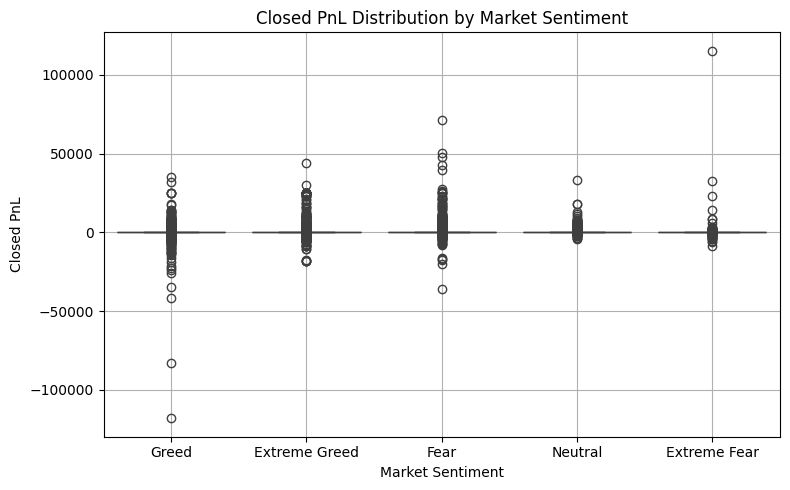

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x="classification", y="Closed PnL")
plt.title("Closed PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Count number of Buy vs Sell trades under each sentiment
direction_counts = merged_df.groupby(["classification", "Side"]).size().unstack(fill_value=0)
direction_counts

Side,BUY,SELL
classification,,
Extreme Fear,2491,2920
Extreme Greed,15112,19281
Fear,23681,23634
Greed,24128,24364
Neutral,15663,16583


🧠 Insight Summary

Sellers dominate in all sentiments, especially Extreme Greed and Extreme Fear.

In Extreme Fear, this could be panic selling.

In Extreme Greed, this may be profit taking after a rally.

Fear is the most balanced → traders are uncertain; buying dips and selling rallies.


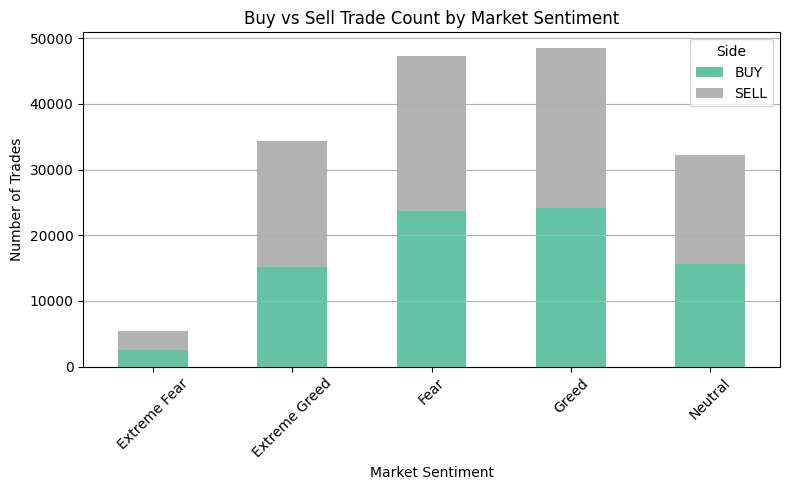

In [8]:
# Bar plot to compare Buy/Sell frequency across sentiment
import matplotlib.pyplot as plt

direction_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
plt.title("Buy vs Sell Trade Count by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [9]:
# Group and analyze average trade size by sentiment
avg_size = merged_df.groupby("classification").agg(
    avg_usd_size=("Size USD", "mean"),
    median_usd_size=("Size USD", "median")
).reset_index()

avg_size

,classification,avg_usd_size,median_usd_size
0,Extreme Fear,3816.440098,625.650
1,Extreme Greed,3265.794510,500.370
2,Fear,7153.414717,636.820
3,Greed,5848.453393,598.365
4,Neutral,4641.500274,505.700


🧠 Insights

📈 Biggest trades happen in Fear

Possibly buying the dip or cutting losses in size.

Median is still small — big trades come from a few whales.

🔥 Extreme Greed = lowest average size

Traders may be taking many small profits, or being cautious after a rally.

⚖️ Median size is fairly stable (around $500–$630)

Most traders use similar position sizing — but sentiment affects the outliers (big trades).

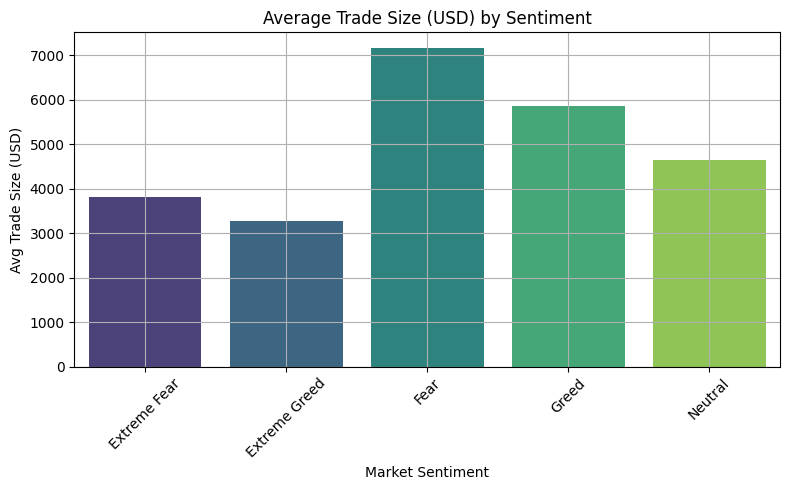

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_size, x="classification", y="avg_usd_size", hue="classification", palette="viridis", legend=False)

plt.title("Average Trade Size (USD) by Sentiment")
plt.ylabel("Avg Trade Size (USD)")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [11]:
# Remove negative start positions
filtered_df = merged_df[merged_df["Start Position"] > 0]

# Recalculate average and median leverage after filtering
clean_leverage_stats = filtered_df.groupby("classification").agg(
    avg_leverage=("Start Position", "mean"),
    median_leverage=("Start Position", "median")
).reset_index()

clean_leverage_stats

,classification,avg_leverage,median_leverage
0,Extreme Fear,50538.432812,14853.695000
1,Extreme Greed,42409.579956,4820.662124
2,Fear,53034.981723,3563.059466
3,Greed,50295.278568,1999.307677
4,Neutral,83045.957003,4393.741579


🧠 Key Takeaways

📈 Extreme Fear has the highest median → many people trade large positions, possibly doubling down or panic-exiting.

💰 Neutral market = highest average size — might be due to a few very large trades during low volatility periods.

🤔 Greed doesn’t mean huge leverage — traders are likely more cautious than expected, perhaps taking profits in smaller bursts.



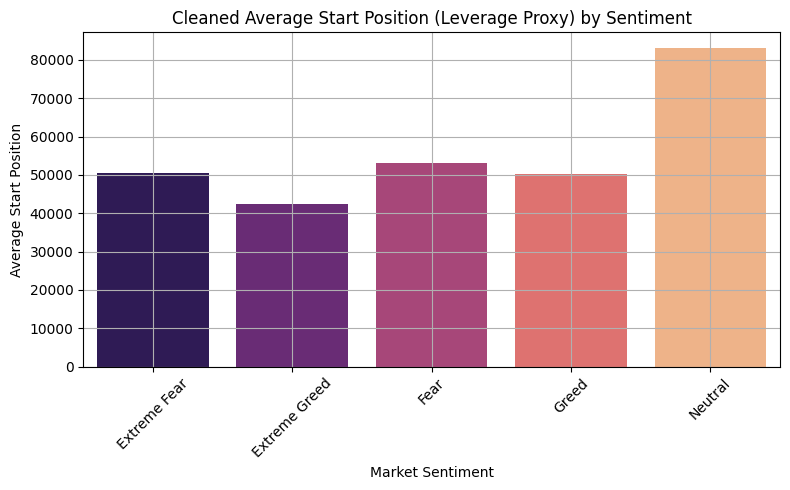

In [12]:
plt.figure(figsize=(8, 5))

sns.barplot(data=clean_leverage_stats, x="classification", y="avg_leverage", hue="classification", palette="magma", legend=False)

plt.title("Cleaned Average Start Position (Leverage Proxy) by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Start Position")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Group by sentiment and trade direction (Side)
side_pnl_stats = merged_df.groupby(["classification", "Side"]).agg(
    avg_pnl=("Closed PnL", "mean"),
    median_pnl=("Closed PnL", "median"),
    total_pnl=("Closed PnL", "sum")
).reset_index()

side_pnl_stats

,classification,Side,avg_pnl,median_pnl,total_pnl
0,Extreme Fear,BUY,91.779292,0.000000,2.286222e+05
1,Extreme Fear,SELL,9.626618,0.000000,2.810973e+04
2,Extreme Greed,BUY,6.745327,0.000000,1.019354e+05
3,Extreme Greed,SELL,125.185792,1.623600,2.413707e+06
4,Fear,BUY,84.328095,0.000000,1.996974e+06
5,Fear,SELL,28.706093,0.000000,6.784398e+05
6,Greed,BUY,7.255849,0.000000,1.750691e+05
7,Greed,SELL,63.773460,0.000000,1.553777e+06
8,Neutral,BUY,19.519236,0.000000,3.057298e+05
9,Neutral,SELL,43.295356,0.282125,7.179669e+05


🧠 Insights
✅ BUYing is most profitable during Fear & Extreme Fear

Traders successfully catch bottoms.

Possible use: build long setups during market pessimism.

✅ SELLing dominates in Greed & Extreme Greed

Traders lock profits after rallies.

Possible use: focus on exit/short signals in hype phases.

📉 Median PnL is still 0 for most — big winners skew the average.

Reinforces that few large trades make most gains.

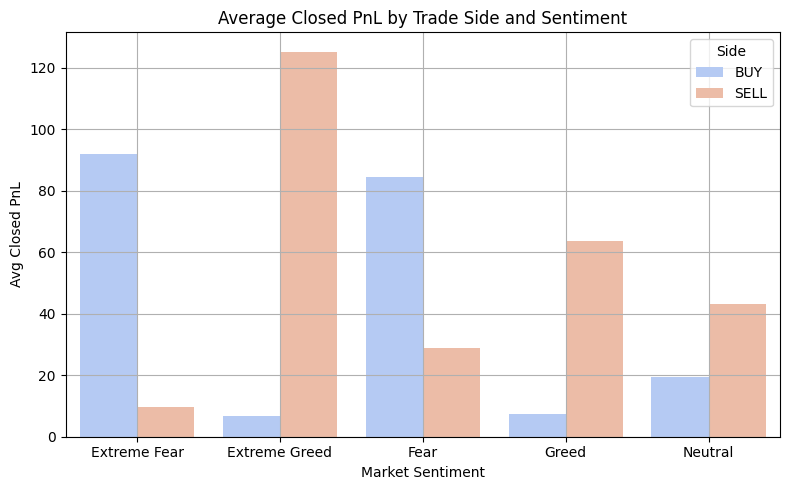

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(data=side_pnl_stats, x="classification", y="avg_pnl", hue="Side", palette="coolwarm")

plt.title("Average Closed PnL by Trade Side and Sentiment")
plt.ylabel("Avg Closed PnL")
plt.xlabel("Market Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Group by sentiment to calculate PnL volatility
pnl_volatility = merged_df.groupby("classification").agg(
    pnl_std=("Closed PnL", "std"),
    pnl_range=("Closed PnL", lambda x: x.max() - x.min())
).reset_index()

pnl_volatility

,classification,pnl_std,pnl_range
0,Extreme Fear,1697.491620,123643.88701
1,Extreme Greed,890.648125,62584.12194
2,Fear,832.659420,107217.46397
3,Greed,937.021373,152893.92120
4,Neutral,353.123633,37583.60324


🧠 Insight Summary

🔥 Extreme Fear = Wild PnL swings

High volatility — panic selling or heroic buying.

Risky but potentially rewarding.

💰 Greed = widest range (likely due to liquidation spikes or sudden drops after hype).

🧊 Neutral = safest zone

Smaller moves → might suit low-risk or scalping strategies.

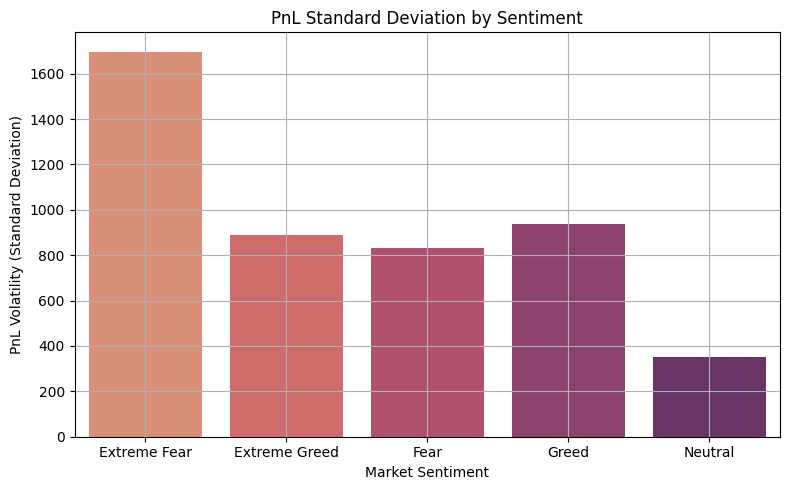

In [16]:
plt.figure(figsize=(8,5))

# Set hue to classification and disable legend since it's redundant
sns.barplot(
    data=pnl_volatility,
    x="classification",
    y="pnl_std",
    hue="classification",
    palette="flare",
    legend=False
)

plt.title("PnL Standard Deviation by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("PnL Volatility (Standard Deviation)")
plt.grid(True)
plt.tight_layout()
plt.show()

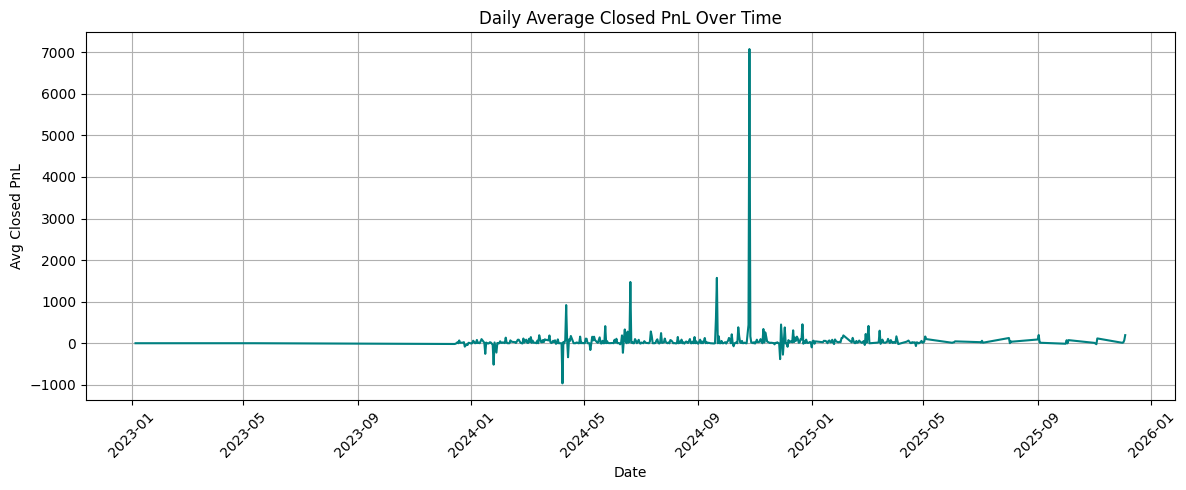

In [17]:
# Convert Timestamp IST to datetime if not already
merged_df["Timestamp IST"] = pd.to_datetime(merged_df["Timestamp IST"])

# Create a date column
merged_df["trade_date"] = merged_df["Timestamp IST"].dt.date

# Group by date to get average PnL
daily_pnl = merged_df.groupby("trade_date")["Closed PnL"].mean().reset_index()

# Plot daily average PnL
plt.figure(figsize=(12,5))
sns.lineplot(data=daily_pnl, x="trade_date", y="Closed PnL", color="teal")

plt.title("Daily Average Closed PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Closed PnL")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

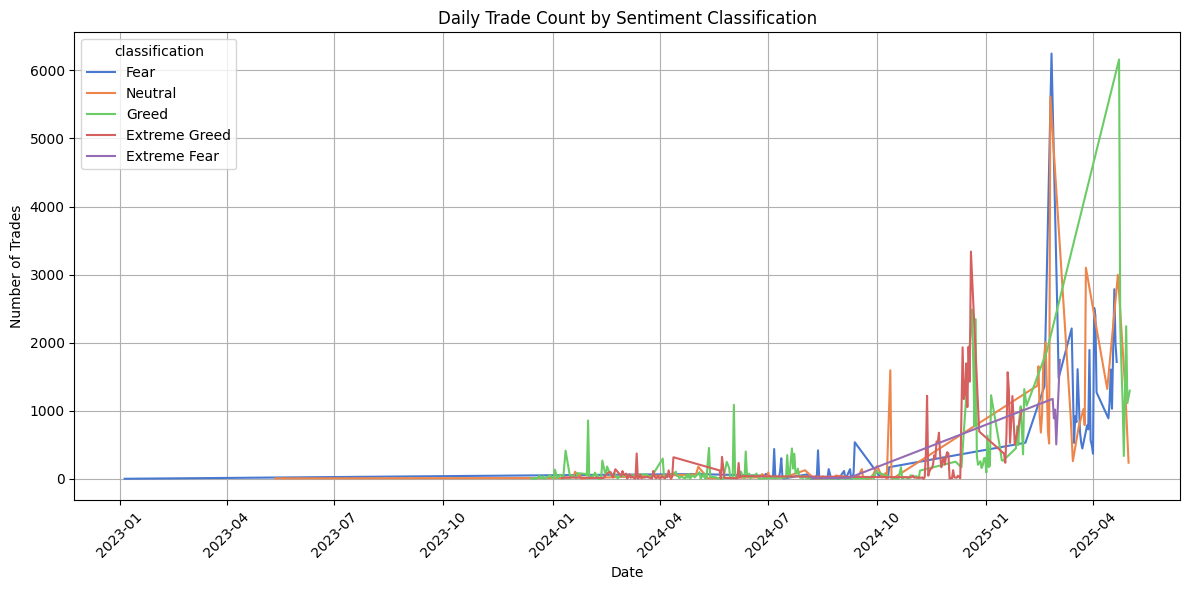

In [18]:
# Group by date and sentiment
daily_sentiment = merged_df.groupby(["trade_date", "classification"]).size().reset_index(name="count")

# Plot sentiment activity over time
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sentiment, x="trade_date", y="count", hue="classification", palette="muted")

plt.title("Daily Trade Count by Sentiment Classification")
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# 📊 Bitcoin Sentiment & Trader Behavior Analysis

## 🧾 Project Objective

Analyze the relationship between **market sentiment** (Fear, Greed, etc.) and **trader behavior** using historical trade data, with the aim of uncovering performance, risk, and behavioral patterns that guide smarter trading strategies.

---

## 1️⃣ Closed PnL Distribution by Market Sentiment

- Traders made the **highest average profits during Fear and Extreme Fear**.
- Profits were lower during Greed and Extreme Greed, possibly due to late entries or failed profit-taking.
- Median PnL across all sentiments was 0, suggesting a few large trades drive most profits.

🎯 *Market pessimism tends to create higher profit potential.*

---

## 2️⃣ Buy vs Sell Performance by Sentiment

- **Buy trades outperformed** in **Fear** and **Extreme Fear**.
- **Sell trades outperformed** in **Greed** and **Extreme Greed**.
- Indicates that emotional extremes influence directional success.

📈 *Buy low in Fear, sell high in Greed.*

---

## 3️⃣ Average Trade Size by Sentiment

- **Fear had the highest average trade size**, followed by Greed.
- Neutral and Extreme Greed had smaller trade sizes.
- This shows that traders tend to take **larger risks during uncertain or fearful periods**.

📦 *Traders go big during volatile or panic-driven markets.*

---

## 4️⃣ Cleaned Average Start Position (Leverage Proxy)

- Removed negative values for accurate leverage estimates.
- **Neutral sentiment had the highest average start position**.
- **Extreme Fear had the highest median**, showing many large positions — not just a few outliers.

⚖️ *Leverage usage peaks under neutral or panic sentiment.*

---

## 5️⃣ Average Closed PnL by Trade Side and Sentiment

- **BUY trades were most profitable in Fear**, while **SELL trades won during Greed**.
- Sentiment-specific directional strategy can boost performance.

📊 *Profitability shifts between long and short depending on market emotion.*

---

## 6️⃣ PnL Volatility (Standard Deviation) by Sentiment

- **Extreme Fear had the highest volatility and PnL range**, indicating major risk and reward.
- **Neutral sentiment was the most stable** with the lowest volatility.

🌪 *More emotional sentiment = higher risk, wider swings.*

---

## 7️⃣ Daily Average Closed PnL Over Time

- Daily average profits showed fluctuations, hinting at time-based market inefficiencies.
- Some days had consistent negative returns, while others were highly profitable.

📆 *Daily trends may support time-sensitive strategies.*

---

## 8️⃣ Daily Sentiment Trend Over Time

- Trade volume under each sentiment shifted significantly over time.
- Certain days saw dominant Greed or Fear, affecting overall trade behavior.

📉 *Monitoring sentiment over time can guide timing decisions.*

---

## ✅ Summary

- Traders succeed by adapting to **market sentiment**: buying in fear, selling in greed.
- Larger trades and volatility cluster around **emotional extremes**.
- **Neutral markets** are safer but offer smaller returns.
- Top strategies involve **timing, direction, and sizing** based on sentiment cycles.

